In [6]:
from os.path import join as oj
import sys
sys.path.append('../src')

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import data
from viz import *
import viz
from data import feats_numerical, feats_categorical, meta
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**load the data**

In [2]:
df_pecarn, df_psrc, common_feats, filtered_feats_pecarn, filtered_feats_psrc = data.load_it_all(dummy=False, impute=True)
feats_binary = [feat for feat in common_feats
                if not feat in feats_numerical + feats_categorical + meta]
# df_pecarn = df_pecarn[df_pecarn.cv_fold.isin(data.pecarn_train_idxs)]
# df_psrc = df_psrc[df_psrc.cv_fold.isin(data.psrc_train_idxs)]

/accounts/projects/vision/.local/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


# see what feats matched / are missing

In [4]:
# matched feats
# for feat in common_feats:
#     print(feat, '\t', df_pecarn[feat].min(), '\t', df_pecarn[feat].max())
print('matched feats', list(filtered_feats_pecarn.intersection(filtered_feats_psrc)))

matched feats ['Race_orig', 'AbdDistention_or_AbdomenPain', 'AbdTenderDegree', 'InitHeartRate', 'Race', 'AbdDistention', 'RtCostalTender', 'Age', 'SeatBeltSign', 'MOI', 'GCSScore_Full', 'AbdTrauma_or_SeatBeltSign', 'AbdTrauma', 'DistractingPain', 'Age<2', 'Hypotension', 'CostalTender', 'ThoracicTrauma', 'InitSysBPRange', 'DecrBreathSound', 'GCSScore', 'LtCostalTender', 'VomitWretch', 'AbdomenPain']


In [7]:
print('psrc but not pecarn')
filtered_feats_psrc.difference(filtered_feats_pecarn)

psrc but not pecarn


{'FemurFracture'}

In [8]:
print('pecarn but not psrc')
print(filtered_feats_pecarn.difference(filtered_feats_psrc))

pecarn but not psrc
{'ThoracicTender', 'Sex'}


# look for feat shift

**continuous features**

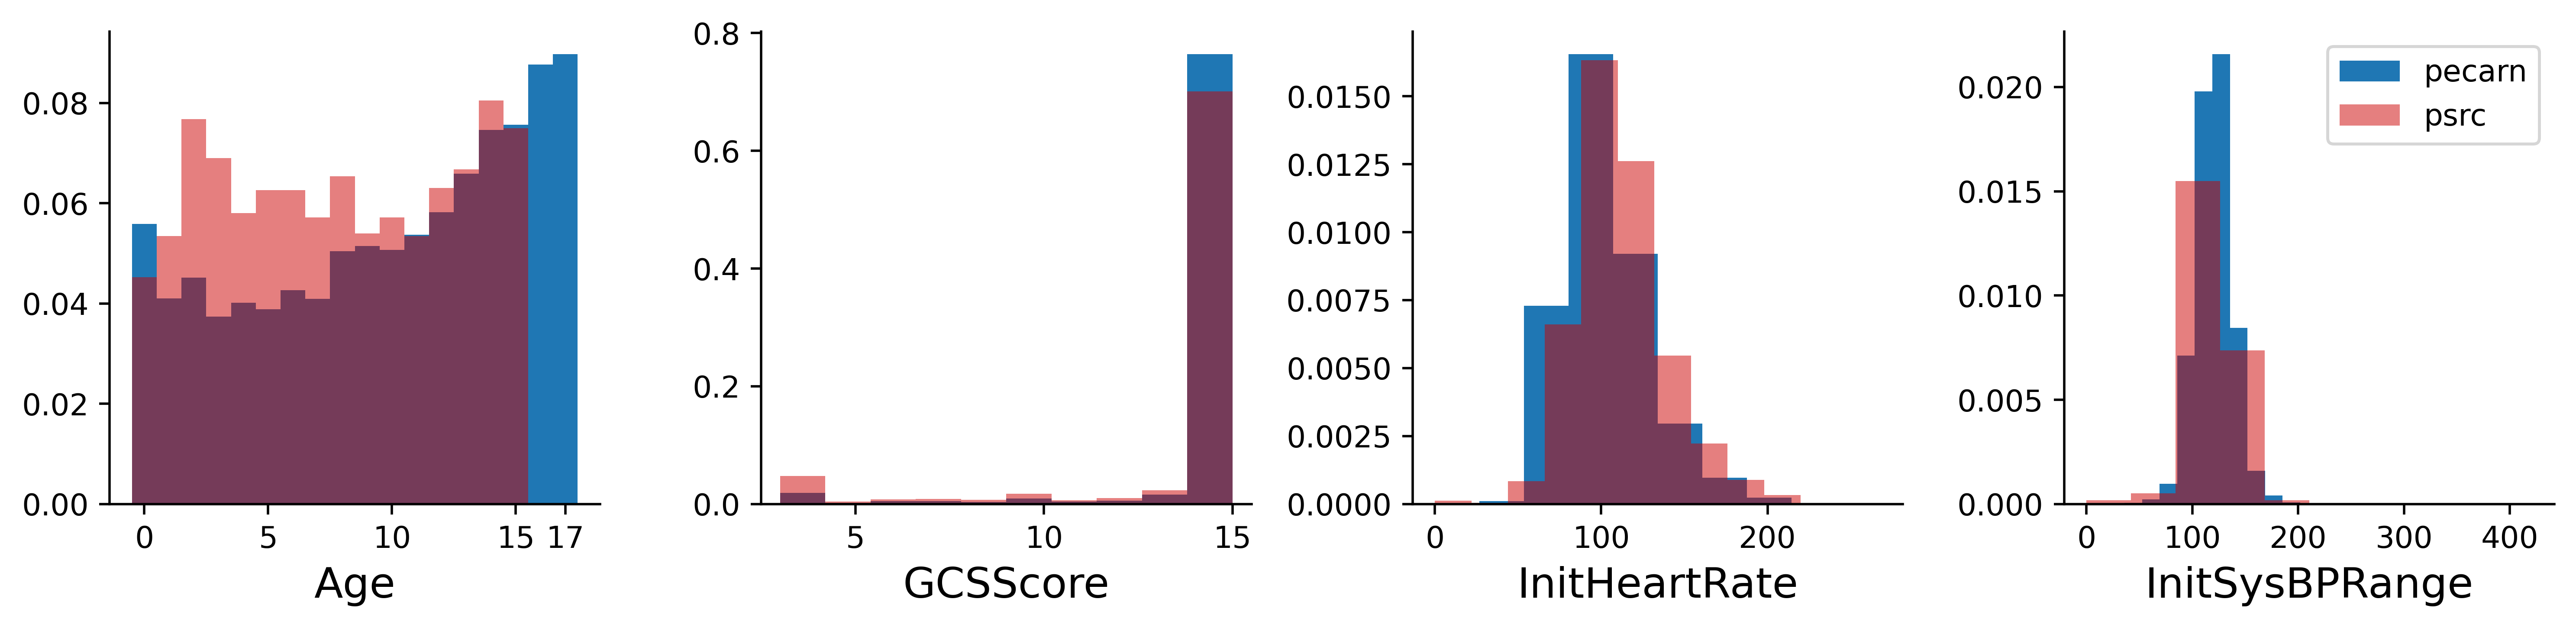

In [7]:
R, C, = 1, 4
plt.figure(figsize=(12, 3), dpi=500)
for i in range(len(feats_numerical)):
    ax = plt.subplot(R, C, i + 1)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    feat = sorted(feats_numerical)[i]
    if feat == 'Age':
        plt.hist(df_pecarn[feat], bins=np.arange(19),
                 density=True, alpha=1, label='pecarn', color=cb)
        plt.hist(df_psrc[feat], bins=np.arange(19),
                 density=True, alpha=0.5, label='psrc', color=cr)
        plt.xticks(np.array([0, 5, 10, 15, 17]) + 0.5, labels=['0', '5', '10', '15', '17'])
    elif feat == 'GCSScore':
        plt.hist(df_pecarn[feat], #bins=np.arange(15),
                 density=True, alpha=1, label='pecarn', color=cb)
        plt.hist(df_psrc[feat], #bins=np.arange(15),
                 density=True, alpha=0.5, label='psrc', color=cr)
        # plt.xticks(np.array([3, 5, 10, 15]) + 0.5, labels=['3', '5', '10', '15'])   
        plt.xlim((2.5, 15.5))
    else:
        plt.hist(df_pecarn[feat], density=True, alpha=1, label='pecarn', color=cb)
        plt.hist(df_psrc[feat], density=True, alpha=0.5, label='psrc', color=cr)
    plt.xlabel(feat, fontsize=14)
#     plt.yticks([])
plt.legend()
plt.tight_layout()
viz.savefig('matched_hists')
plt.show()

**categorical features**

In [ ]:
R, C = len(feats_categorical), 1
plt.figure(figsize=(6, 8), dpi=200)
# print(feats_categorical)
for i in range(R):
    plt.subplot(R, C, i + 1)
    feat = feats_categorical[i]
    vals_unique = np.unique(np.hstack((df_pecarn[feat], df_psrc[feat]))).tolist()
    n = len(vals_unique)
    frac_pecarn = np.array([(df_pecarn[feat]==val).sum() for val in vals_unique]) / df_pecarn.shape[0]
    frac_psrc = np.array([(df_psrc[feat]==val).sum() for val in vals_unique]) / df_psrc.shape[0]
    
    width = 0.4
    plt.barh(np.arange(n), frac_pecarn, height=0.4, label='pecarn', color=cb)
    plt.barh(np.arange(n) - width, frac_psrc, height=0.4, label='psrc', color=cr)
    plt.yticks(np.arange(n) - width + 0.2, vals_unique)
    plt.xlabel('fraction of patients which have this')

    plt.xticks(rotation='vertical')
    plt.title(feat)

plt.legend()
plt.tight_layout()
viz.savefig('matched_hists')
plt.show()

**binary feats**

In [ ]:
R, C = 3, 4
n = len(feats_binary)
def true_or_yes(vals):
    return (vals==True) | (vals=='yes')
frac_psrc = true_or_yes(df_psrc[feats_binary]).mean().values
frac_pecarn = true_or_yes(df_pecarn[feats_binary]).mean().values

width = 0.4
plt.figure(dpi=500, figsize=(3, 6))
plt.barh(np.arange(n), frac_pecarn, height=0.4, label='pecarn', color=cb)
plt.barh(np.arange(n) - width, frac_psrc, height=0.4, label='psrc', color=cr)
plt.yticks(np.arange(n) - width + 0.2, feats_binary)
plt.xlabel('fraction of patients which have this')
plt.legend()
plt.show()

**missing features**

In [ ]:
R, C = 3, 4
feats_all = [feat for feat in common_feats
         if not feat in meta]
n = len(feats_all)
frac_psrc = (df_psrc[feats_all]=='unknown').mean().values
frac_pecarn = (df_pecarn[feats_all]=='unknown').mean().values

width = 0.4
plt.figure(dpi=300, figsize=(3, 6))
plt.xlabel('Fraction of patients\nmissing this feature')
plt.barh(np.arange(n), frac_pecarn, height=0.4, label='pecarn', color=cb)
plt.barh(np.arange(n) - width, frac_psrc, height=0.4, label='psrc', color=cr)
plt.yticks(np.arange(n) - width + 0.2, feats_all)

plt.legend()
plt.show()

**write csvs**

In [6]:
df_pecarn.astype('object').describe().transpose().to_csv('processed/pecarn_vars.csv')
df_psrc.astype('object').describe().transpose().to_csv('processed/psrc_vars.csv')

# how are vars related to outcome

In [7]:
def get_risks(df, feat, vals_unique, outcome='iai_intervention'):
    '''Return iai with intervention as a percentage
    '''
    risks = []
    for val in vals_unique:
        risks.append(df[df[feat]==val][outcome].mean())
    return np.array(risks) * 100

In [ ]:
feats = feats_categorical
R, C = len(feats), 1
plt.figure(figsize=(6, 21), dpi=200)

# feats = ['Sex', 'Age_discrete']
# plt.figure(figsize=(6, 8), dpi=200)


def agecut(age): # inclusive on right end
    return pd.cut(age, bins=(-1, 4, 9, 1000), labels=['<5', '5-9', '>9'])
df_psrc['Age_discrete'] = agecut(df_psrc['Age'])
df_pecarn['Age_discrete'] = agecut(df_pecarn['Age'])


for i in range(R):
    WIDTH = 0.4
    plt.subplot(R, C, i + 1)
    feat = feats[i]
    
    # get unique values
    if feat in df_psrc.keys(): # need to check bc Sex is not there
        vals_unique = list(set(df_pecarn[feat].unique().tolist() + df_psrc[feat].unique().tolist()))
    else:
        vals_unique = np.unique(df_pecarn[feat]).tolist()
        WIDTH = 0.2
    n = len(vals_unique)
    
    # plot pecarn
    risks = get_risks(df_pecarn, feat, vals_unique)
    plt.barh(np.arange(n), risks, height=0.4, label='pecarn', color=cb) #, color=cb)
    plt.yticks(np.arange(n) - WIDTH + 0.2, vals_unique, fontsize=18)
    plt.xlabel('IAI-I Risk (%)', fontsize=18)
    plt.xticks(rotation='vertical')
    plt.title(feat, fontsize=18)
    
    if feat in df_psrc.keys(): # need to check bc Sex is not there
        risks = get_risks(df_psrc, feat, vals_unique)
        plt.barh(np.arange(n) - WIDTH, risks, height=0.4, label='psrc', color=cr) #, color=cr)

plt.legend(fontsize=18)
plt.tight_layout()
plt.show()